In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
# 导入项目中的模块
import networks
from options import Options
from pps_calculator import *

## 函数定义

In [2]:
def load_models(model_path="./logs/nonlambertian_2025-08-28-21-59-37/models/weights_29", device=torch.device("cuda")):
    print(f"正在加载模型: {model_path}")
    import sys
    
    # 设置模型参数 - 修复Jupyter环境中的参数解析问题
    opt = Options()
    # 在Jupyter环境中避免解析命令行参数
    original_argv = sys.argv
    sys.argv = [original_argv[0]]  # 只保留脚本名，移除其他参数
    try:
        opt = opt.parse()
    finally:
        sys.argv = original_argv  # 恢复原始参数
    
    opt.height = 256
    opt.width = 320
    
    # 初始化网络
    models = {}
    
    # 编码器
    models["encoder"] = networks.ResnetEncoder(opt.num_layers, False)
    
    # 深度解码器
    models["depth"] = networks.DepthDecoder(models["encoder"].num_ch_enc, [0])
    
    # 分解编码器
    models["decompose_encoder"] = networks.ResnetEncoder(opt.num_layers, False)
    
    # 分解解码器
    models["decompose_decoder"] = networks.DecomposeDecoder(models["decompose_encoder"].num_ch_enc)
    
    # Pose编码器
    models["pose_encoder"] = networks.ResnetEncoder(opt.num_layers, False, num_input_images=2)
    
    # Pose解码器
    models["pose_decoder"] = networks.PoseDecoder(models["pose_encoder"].num_ch_enc, 
                                                    num_input_features=1, 
                                                    num_frames_to_predict_for=2)
    
    # 加载权重
    model_weights = {
        "encoder": "encoder.pth",
        "depth": "depth.pth", 
        "decompose_encoder": "decompose_encoder.pth",
        "decompose_decoder": "decompose.pth",
        "pose_encoder": "pose_encoder.pth",
        "pose_decoder": "pose.pth"
    }
    
    missing_weights = []
    for model_name, weight_file in model_weights.items():
        weight_path = os.path.join(model_path, weight_file)
        if os.path.exists(weight_path):
            try:
                model_dict = models[model_name].state_dict()
                pretrained_dict = torch.load(weight_path, map_location=device)
                
                # 过滤掉不匹配的键，只保留当前模型中存在的参数
                filtered_dict = {k: v for k, v in pretrained_dict.items() \
                               if k in model_dict and v.shape == model_dict[k].shape}
                
                # 使用strict=False允许部分加载，忽略不匹配的键
                models[model_name].load_state_dict(filtered_dict, strict=False)
            except Exception as e:
                missing_weights.append(model_name)
        else:
            missing_weights.append(model_name)

    # 移动到设备并设置为评估模式
    for model in models.values():
        model.to(device)
        model.eval()
        
    return models


In [3]:
def predict_depth_and_albedo(models, image_path, device):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((256, 320)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0).to(device)
    """预测深度和反照率"""
    with torch.no_grad():
        # 使用encoder和depth_decoder预测深度
        features = models["encoder"](image)
        depth_outputs = models["depth"](features)
        depth, _ = disp_to_depth(depth_outputs[("disp", 0)])
        
        # 使用decompose_encoder和decompose_decoder预测反照率
        decompose_features = models["decompose_encoder"](image)
        albedo, shading, specular = models["decompose_decoder"](decompose_features)
        
    return depth, albedo, shading, specular

def disp_to_depth(disp, min_depth=0.1, max_depth=150.0):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

In [4]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [131]:
def visualize_results(results, net_M=True):
    """
    Args:
        results: PPS计算结果字典
    """
    try:
        import matplotlib.pyplot as plt
        
        # 选择第一个批次的数据进行可视化
        A = results['A'][0, 0].detach().cpu().numpy()
        L = results['L'][0].detach().cpu().numpy()
        N = results['N'][0].detach().cpu().numpy()
        depth_vis = results['depth'][0, 0].detach().cpu().numpy()
        L_dot_N = results['L_dot_N'][0, 0].detach().cpu().numpy()
        PPS = results['PPS'][0, 0].detach().cpu().numpy()
        albedo_np = results['albedo'][0].detach().cpu().numpy()
        image = results['image'][0].detach().cpu().numpy()
        lambertian = results['lambertian'][0].detach().cpu().numpy()
        shading = results['shading'][0].detach().cpu().numpy()
        image_scaled = F.interpolate(
                results['image'].detach().cpu(),                               # 输入
                size=albedo_np.shape[-2:],                    # 目标高宽
                mode='bilinear',                     # 或 'area'/'bicubic'/'nearest'
                align_corners=False                  # 必须 False（官方推荐）
        )

        if net_M:
            specular = results['specular'][0].detach().cpu().numpy()
        else:
            specular = (image_scaled[0] - results['albedo'][0].detach().cpu() * results['shading'][0].detach().cpu()).numpy()

        albedo_vis = np.transpose(albedo_np, (1, 2, 0))
        # albedo_resized = np.array(Image.fromarray((albedo_vis * 255).astype(np.uint8)).resize((PPS.shape[1], PPS.shape[0]), Image.LANCZOS)) / 255.0
        lambertian_vis = np.transpose(lambertian, (1, 2, 0))
        image = np.transpose(image, (1, 2, 0))
        shading = np.transpose(shading, (1, 2, 0))
        print(specular.shape)
        specular = np.transpose(specular, (1, 2, 0))
        image_scaled = np.transpose(image_scaled.squeeze(0), (1, 2, 0))

        # 创建5x2的子图布局
        fig, axes = plt.subplots(6, 2, figsize=(14, 26))
        
        # A(X) - 衰减系数
        im1 = axes[0, 0].imshow(A, cmap='viridis')
        axes[0, 0].set_title('A(X)')
        plt.colorbar(im1, ax=axes[0, 0])
        
        # L(X) - 光照方向 (显示x分量)
        im2 = axes[0, 1].imshow(L[0], cmap='coolwarm')
        axes[0, 1].set_title('L(X)')
        plt.colorbar(im2, ax=axes[0, 1])
        
        # N(X) - 法向量 (显示z分量)
        im3 = axes[1, 0].imshow(N[2], cmap='coolwarm', vmin=0, vmax=np.percentile(N[2], 95))
        axes[1, 0].set_title(f'N(X) (0-{np.percentile(N[2], 95):.1f})')
        plt.colorbar(im3, ax=axes[1, 0])
        
        # 深度图 - 使用归一化显示
        im4 = axes[1, 1].imshow(depth_vis, cmap='plasma', vmin=0, vmax=np.percentile(depth_vis, 95))
        axes[1, 1].set_title(f'Depth (0-{np.percentile(depth_vis, 95):.1f})')
        plt.colorbar(im4, ax=axes[1, 1])
        
        # L·N - 光照方向与法向量的点积
        im5 = axes[2, 0].imshow(L_dot_N, cmap='RdBu')
        axes[2, 0].set_title('L·N')
        plt.colorbar(im5, ax=axes[2, 0])
        
        # PPS = A × (L·N) - 最终的光照效果
        im6 = axes[2, 1].imshow(PPS, cmap='viridis')
        axes[2, 1].set_title('PPS = A × (L·N)')
        plt.colorbar(im6, ax=axes[2, 1])

        specular_rev = 1 - specular
        axes[3, 0].imshow(specular_rev)
        axes[3, 0].set_title('Specular')

        im_shading = axes[3, 1].imshow(shading)
        axes[3, 1].set_title('Shading')
        plt.colorbar(im_shading, ax=axes[3, 1])

        
        # 反照率 - 现在可以正确显示RGB图像
        im7 = axes[4, 0].imshow(albedo_vis) 
        axes[4, 0].set_title('Albedo')
        
        # PPS * Albedo - 结合反照率的光照效果

        im8 = axes[4, 1].imshow(lambertian_vis)
        axes[4, 1].set_title('PPS × Albedo')

        # 显示原始图像
        axes[5, 0].imshow(image)
        axes[5, 0].set_title('Original Image')
        axes[5, 0].axis('off')

        lam_shading = image_scaled.squeeze(0) - specular
        im9 = axes[5, 1].imshow(lam_shading)
        axes[5, 1].set_title(f'image - specular')
        plt.colorbar(im9, ax=axes[5, 1])

        plt.tight_layout()
        plt.show()
    except ImportError:
        print("\n提示: 安装matplotlib可以进行结果可视化")
        print("pip install matplotlib")


## 参数定义

In [123]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

light_pos = torch.tensor([0, 0, -0.001], device=device)
light_dir = torch.tensor([0, 0, 1], device=device)

dataset_id = 3
keyframe_id = 1
frame_id = 1
f_str = "{:010d}.png".format(frame_id)
color_path = f"/mnt/data/publicData/MICCAI19_SCARED/train/dataset{dataset_id}/keyframe{keyframe_id}/image_02/data/{f_str}"
weights_folder = './logs_v3/Change3.1/models/weights_29'

In [70]:
K_O = [
        [
            1035.30810546875,
            0.0,
            596.9550170898438
        ],
        [
            0.0,
            1035.087646484375,
            520.4100341796875
        ],
        [
            0.0,
            0.0,
            1.0
        ]
    ]

K = torch.from_numpy(np.array(K_O, dtype=np.float32)).to(device)


## 应用

正在加载模型: ./logs_v3/Change3.1/models/weights_29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.64138013..1.2378111].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00038980338..0.97268385].


(3, 256, 320)


/tmp/ipykernel_213698/576278383.py:97: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  lam_shading = image_scaled.squeeze(0) - specular


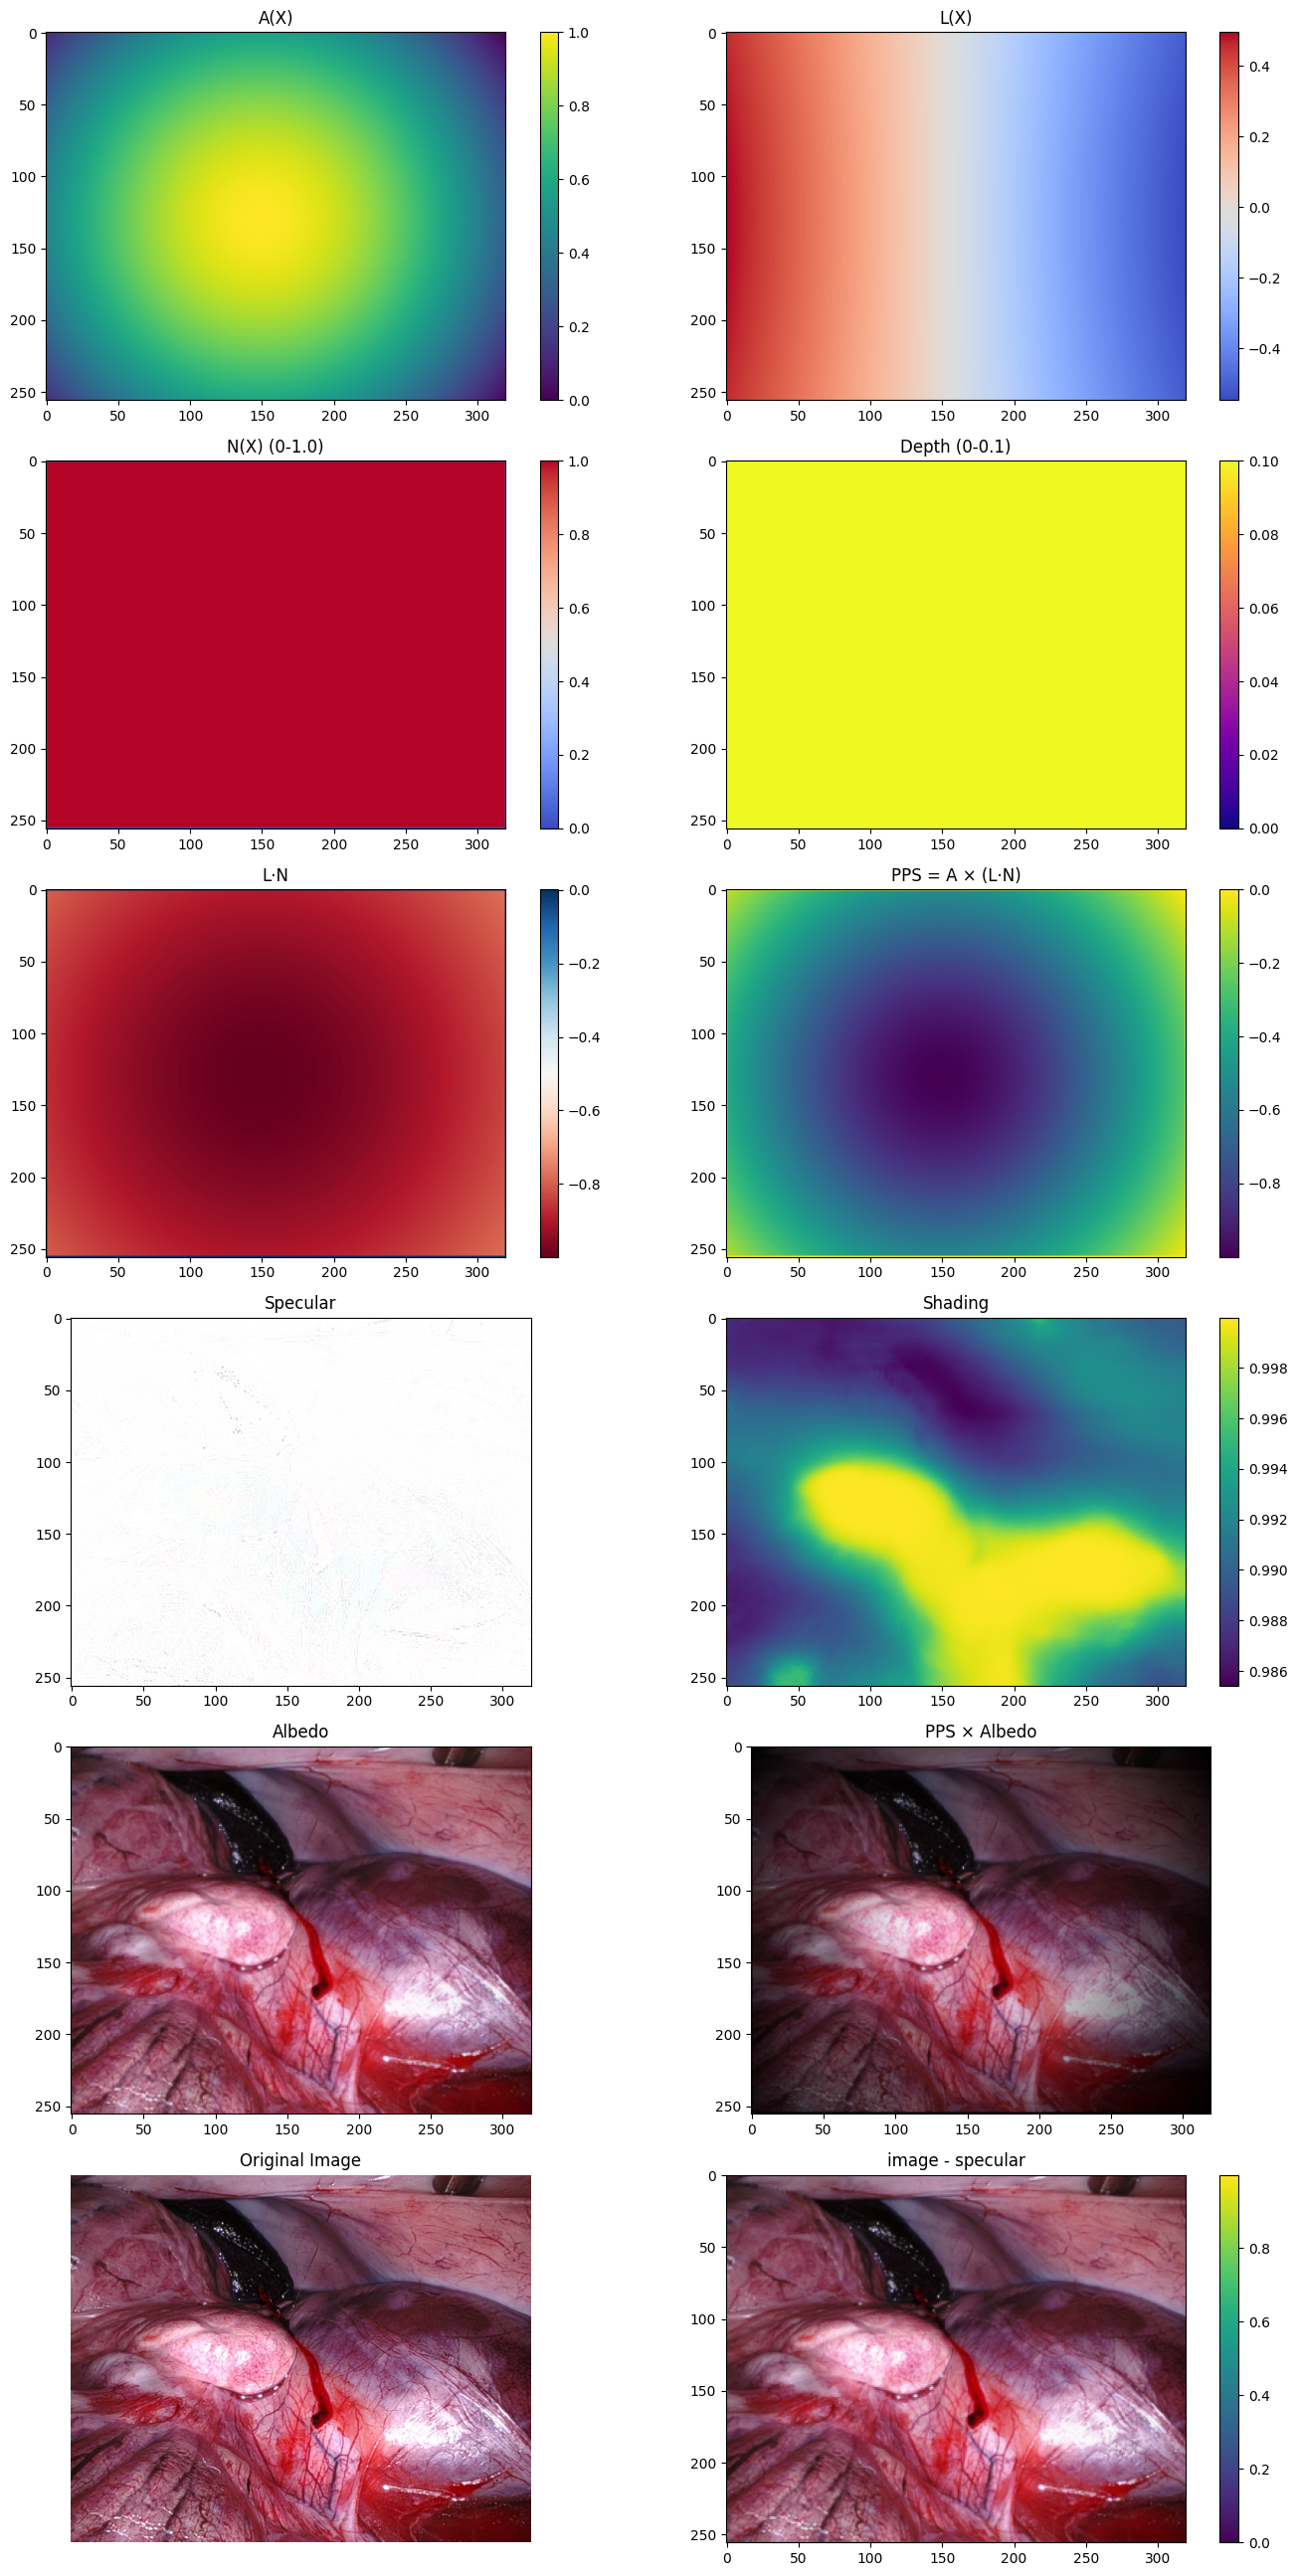

In [132]:
model = load_models(device=device, model_path=weights_folder)
depth, albedo, shading, specular = predict_depth_and_albedo(model, color_path, device)
image = pil_loader(color_path)
image = transforms.ToTensor()(image)
image = image.unsqueeze(0).to(device)
result = calculate_pps_parameters(1.0 / depth, image, K, light_pos, light_dir)
albedo = handle_albedo(albedo)
lam_res = calculate_lambertian(result, albedo)
result.update(lam_res)
result["albedo"] = albedo
result["shading"] = shading
result["specular"] = specular
result["image"] = image
visualize_results(result, False)


In [89]:
def visualize_L_mask(images, speculars):
	specular = speculars[0]
	image = images
	th = 0.96
	target_size = specular.shape[-2:]          # (H_new, W_new)
	image_scaled = F.interpolate(
			image,                               # 输入
			size=target_size,                    # 目标高宽
			mode='bilinear',                     # 或 'area'/'bicubic'/'nearest'
			align_corners=False                  # 必须 False（官方推荐）
	)

	intensity = image_scaled.mean(dim=1, keepdim=True)  # grayscale
	mask = (intensity > th).float()

	L_mask = ((1 - mask) * (specular**2))

	image_show = image_scaled.squeeze().cpu().numpy()
	image_show = np.transpose(image_show, (1, 2, 0))
	L_mask_show = L_mask.squeeze().cpu().numpy()
	L_mask_show = np.transpose(L_mask_show, (1, 2, 0))
	mask_show = mask.squeeze().cpu().numpy()

	overlay_img = image_show.copy().astype(np.float32)
	# 在原图上叠加红色高亮区域
	overlay_img[:, :, 0] = np.where(mask_show > 0.5, 1.0, overlay_img[:, :, 0])  # 红色通道
	overlay_img[:, :, 1] = np.where(mask_show > 0.5, 0.0, overlay_img[:, :, 1])  # 绿色通道置0
	overlay_img[:, :, 2] = np.where(mask_show > 0.5, 0.0, overlay_img[:, :, 2])  # 蓝色通道置0

	fig, axes = plt.subplots(2, 2, figsize=(15, 12))

	axes[0, 0].imshow(image_show)
	axes[0, 0].axis('off')
	axes[0, 1].imshow(mask_show)
	axes[0, 1].axis('off')
	axes[1, 0].imshow(L_mask_show*10000)
	axes[1, 0].axis('off')
	axes[1, 1].imshow(overlay_img)
	axes[1, 1].axis('off')

	plt.show()


In [ ]:
visualize_L_mask(image, specular)